# Tutorial 1: One-Dimensional Sinusoid

Our goal will be to train a neural network to predict one-dimensional sinusoidal function, given as: 

$
y = x \sin(x)
$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jenn

In [3]:
SEED = 123

### Synthetic Data

In a first step, let's load the test function:

In [4]:
test_function = jenn.synthetic.Sinusoid

Next, let's define the domain over which we will collect synthetic training data:

In [5]:
lb, ub = (-3.14, 3.14)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [6]:
x_train, y_train, dydx_train = test_function.sample(m_lhs=0, m_levels=4, lb=lb, ub=ub)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [7]:
x_test, y_test, dydx_test = test_function.sample(m_lhs=30, m_levels=0, lb=lb, ub=ub)

### Training

Training can be done in one line of code. In this case, we'll train both a regular neural networks (nn):

In [8]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[1, 12, 1],
).fit(
    x=x_train, 
    y=y_train, 
    lambd=0.1, 
    is_normalize=False,
    random_state=SEED, 
)

CPU times: user 168 ms, sys: 1.54 ms, total: 169 ms
Wall time: 169 ms


and also a gradient-enhanced neural net (genn) for comparison: 

In [9]:
%%time 
genn = jenn.model.NeuralNet(
    layer_sizes=[1, 12, 1]
).fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train, 
    lambd=0.1,  
    is_normalize=False,
    random_state=SEED, 
)

CPU times: user 195 ms, sys: 875 μs, total: 196 ms
Wall time: 195 ms


### Visualization

With only four data points, a near-perfect fit is obtained using gradient-enhancement, whereas a regular neural net fails to capture the response:   

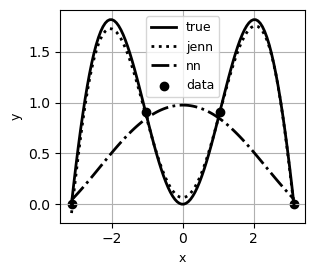

In [10]:
jenn.utils.plot.sensitivity_profiles(
    f=[jenn.synthetic.Sinusoid.evaluate, genn.predict, nn.predict], 
    x_min=x_train.min(), 
    x_max=x_train.max(), 
    x_true=x_train, 
    y_true=y_train, 
    resolution=100, 
    legend=['true', 'jenn', 'nn'], 
    xlabels=['x'], 
    ylabels=['y'],
    show_cursor=False
)

### Goodness of Fit: Partials

#### Gradient-Enhanced 

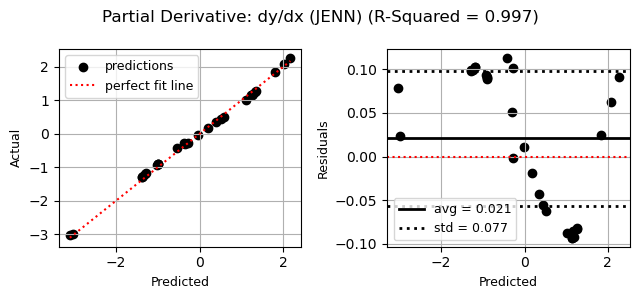

In [11]:
jenn.utils.plot.goodness_of_fit(
    y_true=dydx_test[0], 
    y_pred=genn.predict_partials(x_test)[0], 
    title="Partial Derivative: dy/dx (JENN)"
)

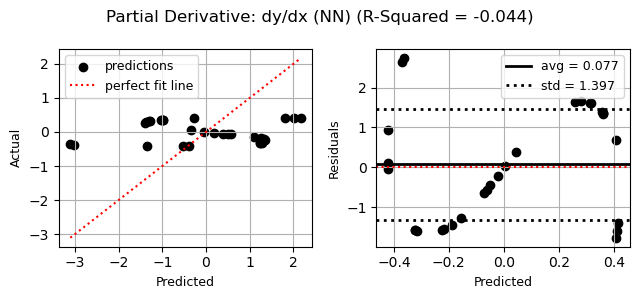

In [12]:
jenn.utils.plot.goodness_of_fit(
    y_true=dydx_test[0], 
    y_pred=nn.predict_partials(x_test)[0], 
    title="Partial Derivative: dy/dx (NN)"
)

### Save / Reload Model

Model parameters are serialized. They can be easily saved as `json` and reloaded later. 

_Save old model_: 

In [13]:
old_model = genn
old_model.save('parameters.json')

_Reload old model_:

In [14]:
new_model = jenn.model.NeuralNet(layer_sizes=[1, 12, 1]).load('parameters.json')

_Verify that old and new model agree_:

In [15]:
assert (new_model.predict(x_test) == old_model.predict(x_test)).all()